In [ ]:
# big test of least squares
# 1. import the b0 map
# import b0map as an object
import numpy as np  
import b0
b0map = b0.b0()
filename_to_import_csv_data_from = r'./data/240619/Thursday_ball_R120_12pts_bvals_shifted.csv'
b0map.import_from_csv(filename_to_import_csv_data_from)
b0map.transfer_coordinates_of_the_path_from_cosi_to_magnet()


# change coordinates to magnet



In [ ]:
print(np.nanmin(b0map.b0Data[:,:,:,0]))
print(np.nanmax(b0map.b0Data[:,:,:,0]))

# spherical decomposition
diameter_of_sphere = b0map.path.radius*2
order = 17
resolution_of_sph_decomp = 10
print(diameter_of_sphere)
b0map.fitSphericalHarmonics(maxorder=order,dsv=diameter_of_sphere,resol=resolution_of_sph_decomp)

resolution_of_sph_fit=8
print('interpolating field with sph order %d, resol %.0f mm'%(order,resolution_of_sph_fit))

b0map.interpolateField(resol=resolution_of_sph_fit,dsv=diameter_of_sphere)



30


<Figure size 640x480 with 0 Axes>

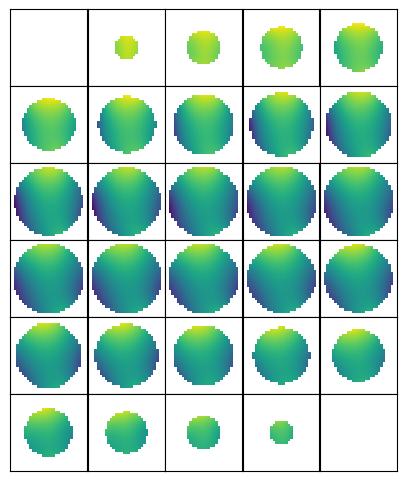

In [94]:
# plot the initial field (interpolated)
# save initial field as 2d plots
plt.figure(0)

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(5, 6))

xvals = b0map.xDim_SPH_fine

shimoffset = np.nanmean(shimField) - np.nanmean(initialField)
d = np.shape(coordinate_grid[0])
print(d[0])


for i in range(5):
    for j in range(6):
        xxx = axes[j,i].imshow(initialField[i+j*5,:,:],clim=[np.nanmin(initialField),np.nanmax(initialField)])
        axes[j,i].xaxis.set_visible(False)
        axes[j,i].yaxis.set_visible(False)
        
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('./pics/init_field_iter2.png',format="png")
plt.savefig('./pics/init_field_iter2.pdf',format="pdf")
#plt.colorbar(mappable=xxx)
plt.show()


In [95]:
print('now we have an interpolated field.')
print(np.shape(b0map.interpolatedField))
print('on a coordinate grid')
print(np.shape(b0map.coord_grid_fine))


now we have an interpolated field.
(30, 30, 30)
on a coordinate grid
(3, 30, 30, 30)


In [ ]:
# lets generate a shim field of one insert.
# Insert 12 ring 2, all rotations pointing to +y direction


In [96]:
# shim magnets positinoing

mu                  = 1e-7

magSizeOuter        = 6*1e-3        #size of shim magnets
bRem                = 1.35 # [T]      #remanence field of shim magnets

#shim tray configuration
def ringposFromTrayNr(trays_ocp):
    trayslitspacing = 9e-3 # [m]
    coordinates = []
    for tray_pos in trays_ocp:
        coordinate = trayslitspacing*tray_pos-4.5e-3 if tray_pos>0 else trayslitspacing*tray_pos+4.5e-3
        coordinates.append(coordinate)
    return coordinates


shimRadius          = 276*1e-3#276*1e-3 <- was set by Tom!      # radius on which the shim magnets are placed

trays_occupied = [-7,-5,1,14] #[-18,-5,1,12] <- 27mm best  [-7,-5,1,14] 997
ringPositions       = ringposFromTrayNr(trays_occupied)#[-121.5*1e-3, -40.5*1e-3, 31.5*1e-3, 121.5*1e-3]#np.linspace(-ringspacingouter,ringspacingouter,4)#np.linspace(-0.1755,0.1755,4)          #np.linspace(-0.2295, .2295, 4) #Z positions to place shin rubgs
print(np.array(ringPositions)*1e3)


[-58.5 -40.5   4.5 121.5]


In [135]:

magsPerSegment      = 7             # number of magnets peer shim tray segment
anglePerSegment     = 19.25 #the angular distance in degrees between the furthest magnets in a shim tray (span of magnets in shim tray)
numSegments         = 12 #corresponds to the number of shim trays


segmentAngles       = np.linspace(0,360, numSegments, endpoint = False)

magAngles           = np.linspace(-anglePerSegment/2, anglePerSegment/2, magsPerSegment) 

print('let us position some magnets on a circumference of a R=%.0f mm YZ circle with X=0'%(shimRadius*1000))

positions = []
for ringPosition in ringPositions:
    for segmentAngle in segmentAngles:
        for magAngle in magAngles:
                       positions.append((ringPosition,shimRadius*np.cos((segmentAngle+magAngle)*np.pi/180), shimRadius*np.sin((segmentAngle+magAngle)*np.pi/180)))

        # check if rings are in the right plane
        #print(positions) 
#!TEMP!!!
tmppos=[]
# finding the insert with min y and x=-58.5 (RING 0)
for position in positions:
    if abs(position[0]+58.5e-3) < 3e-3:
        if position[1] < -shimRadius*np.cos(np.pi/12):
            print(position)
            tmppos.append(position)
positions = tmppos


#pos = [0,-20e-3,60e-3]
#positions = []
#positions.append(pos)
#print(len(positions))


let us position some magnets on a circumference of a R=276 mm YZ circle with X=0
(-0.0585, -0.27211479674710887, 0.04614691096140273)
(-0.0585, -0.2742709847847707, 0.03084520878827214)
(-0.0585, -0.27556740718070843, 0.015446815196073632)
(-0.0585, -0.276, 3.3800251656466954e-17)
(-0.0585, -0.27556740718070843, -0.015446815196073443)
(-0.0585, -0.2742709847847707, -0.030845208788271954)
(-0.0585, -0.27211479674710887, -0.04614691096140278)


In [ ]:

import matplotlib.pyplot as plt
for idx,position in enumerate(positions):

    plt.scatter(position[1],position[2],color = [idx/len(positions),0,0])

plt.xlabel('Y')
plt.ylabel('Z')


initialField = b0map.interpolatedField
numMags = len(positions)
coordinate_grid = b0map.coord_grid_fine



magnetFields = np.zeros((np.shape(initialField)+(3,numMags)), dtype = np.float32)
magnetFields_fair = np.zeros((np.shape(initialField)+(3,numMags)), dtype = np.float32)


def magnetization(bRem, dimensions, shape = 'cube', evalDistance = 1):
    #Use the analytical expression for the z component of a cube magnet to estimate
    #dipole momentstrength for correct scaling. Dipole approximation only valid 
    #far-ish away from magnet, comparison made at 1 meter distance.
    if shape == 'cube':
        b_analytic = (bRem/np.pi) *(np.arctan2(dimensions**2, 2*evalDistance *np.sqrt(4*(evalDistance**2) + 2*(dimensions**2)))-\
                        np.arctan2(dimensions**2, 2*(dimensions + evalDistance)*\
                                   np.sqrt(4*((dimensions+evalDistance)**2)+2*(dimensions**2))))
    
        dip_mom = b_analytic * (dimensions/2 + evalDistance)**3 /(2*mu) #strength of the dipole moment
    
    return dip_mom

from utils import shimming_magnet

shimming_magnets = []

DSV = 2*max(b0map.xDim_SPH_fine)#b0map.path.radius*2

dip_mom = magnetization(bRem=bRem,dimensions=magSizeOuter)
dip_vec = mu*np.array([0,dip_mom,0]) #initially along y

for idx1, position in enumerate(positions):
    magnet = shimming_magnet.shimming_magnet(position=position,rotation_yz=0)
    magnet.render_field(grid=coordinate_grid)
    #magnetFields[:,:,:,:,idx1] = magnet.singleMagnet(position, grid=coordinate_grid)
    magnetFields[:,:,:,:,idx1] = magnet.OLD_singleMagnet(position=position,dipoleMoment = dip_vec, 
                                                         simDimensions=[DSV*1e-3,DSV*1e-3,DSV*1e-3],
                                                         resolution=1/resolution_of_sph_fit*1e3,
                                                         plotFields=False)[:,:,:,:] #singleMagnet(position, grid=coordinate_grid)

    #magnetFields_fair[:,:,:,:,idx1] = magnet.singleMagnet(position=position,grid=coordinate_grid,plotFields=False)

    shimming_magnets.append(magnet)

magnetFields *= 1e3

print(DSV)


In [ ]:
# cheap vs real fields
# DO NOT RUN
plt.cla()

v=max(b0map.xDim_SPH_fine)
magnet_index = 0
for i in range(5):
    alpha = i*2*np.pi/4
    cheapfield = magnetFields[12,:,:,2,magnet_index]*np.cos(alpha)+magnetFields[12,:,:,1,magnet_index]*np.sin(alpha)+\
        magnetFields[12,:,:,2,magnet_index+14]*np.cos(alpha)+magnetFields[12,:,:,1,magnet_index+14]*np.sin(alpha)
    plt.imshow(cheapfield,vmin=-1e-3, vmax=1e-3,extent=[-v,v,v,-v])
    plt.title('cheap %.0f deg'%(alpha*180/np.pi))
    plt.xlabel('Z')
    plt.ylabel('Y')
    
    plt.show()
    magnet = shimming_magnets[magnet_index]
    magnet2 = shimming_magnets[magnet_index+14]
    magnet.rotation_yz = alpha
    magnet2.rotation_yz = alpha    
    magnet.render_field(grid=coordinate_grid)
    magnet2.render_field(grid=coordinate_grid)

    plt.imshow(1e3*(magnet.B0[12,:,:,2]+magnet2.B0[12,:,:,2]),vmin=-1e-3, vmax=1e-3,extent=[-v,v,v,-v])
    plt.title('real %.0f deg'%(alpha*180/np.pi))
    plt.xlabel('Z')
    plt.ylabel('Y')
    plt.show()

In [ ]:
print(np.sqrt(336))
plt.figure(0)

fig, axes = plt.subplots(nrows=7, ncols=7, figsize=(10, 10))
for i in range(7):
    for j in range(7):
        slice_idx = 12
        alpha = 0
        magnet_index = i+j*7
        magnet = shimming_magnets[magnet_index]
        cheapfield = magnetFields[slice_idx,:,:,2,magnet_index]*np.cos(alpha)+magnetFields[slice_idx,:,:,1,magnet_index]*np.sin(alpha)
        axes[j,i].imshow(1e3*magnet.B0[slice_idx,:,:,2]-cheapfield,vmin=-5e-10, vmax=5e-10)#.imshow(np.transpose(np.sqrt(np.imag(img.T[:,:,i+j*5])**2+np.real(img.T[:,:,i+j*5])**2)),cmap='grey')
        axes[j,i].xaxis.set_visible(False)
        axes[j,i].yaxis.set_visible(False)
        
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('./pics/individual_magnets_real-cheap_fields.png',format="png")
plt.savefig('./pics/individual_magnets_real-cheap_fields.pdf',format="pdf")

plt.show()

In [ ]:
# visualize the field of one magnet
resolution = 1/resolution_of_sph_fit*1e3

X = b0map.xDim_SPH_fine*1e0
Y = b0map.yDim_SPH_fine*1e0
Z = b0map.zDim_SPH_fine*1e0

ONEMAGNETFIELD = magnetFields[:,:,:,:,0]*0

ax = plt.figure().add_subplot()
for idx in range(0,7,1):

    position = positions[idx]

    x,y,z = coordinate_grid
    y2d, z2d = np.meshgrid(Y,Z,indexing='xy')

    ONEMAGNETFIELD += magnetFields[:,:,:,:,idx]#+magnetFields[:,:,:,:,idx+14]

    
    
    
    ax.plot(position[1]*1000,position[2]*1000,'x')
scale = 5e-0
yzsliceindex = 3
ax.contourf(y2d,z2d,ONEMAGNETFIELD[yzsliceindex,:,:,2],cmap='viridis',levels=64)#,vmin = -scale, vmax= scale)

#ax.plot(min(Y),min(Z),'ko')
#ax.plot(max(Y),max(Z),'ko')

ax.set_xlabel('Y')
ax.set_ylabel('Z')
ax.set_xlim(-290,290)
ax.set_ylim(-290,290)
ax.set_aspect(1)
                
ax.set_title('z component of shim field YZ plane, X= %.2f'%(X[yzsliceindex]))

plt.savefig('./pics/total_magnets_fields.png',format="png")
plt.savefig('./pics/total_magnets_fields.pdf',format="pdf")

plt.show()

In [ ]:
# mask the magnet fields
# DSV = b0map.path.radius*2 # DEFINED ABOVE!
DSV_INNER = b0map.path.radius*1.96#1.95 # DEFINED ABOVE!
# make a spherical mask with diameter DSV
sphereMask = np.zeros(np.shape(coordinate_grid[0]), dtype = float)
sphereMask[np.square(coordinate_grid[0]) + np.square(coordinate_grid[1]) + np.square(coordinate_grid[2]) <= (DSV/2)**2] = 1 
sphereMask[np.square(coordinate_grid[0]) + np.square(coordinate_grid[1]) + np.square(coordinate_grid[2]) <= (DSV_INNER/2)**2] = 0 

sphereMask[sphereMask == 0] = np.nan

print(np.shape(magnetFields))

maskedFields = magnetFields[sphereMask == 1, :,:].astype(float)
maskedFields_stacked = np.hstack((maskedFields[:,1,:],maskedFields[:,2,:])) # WE HAVE Y AND Z


plt.imshow(maskedFields_stacked) #



In [ ]:
# masking the magnet fields

print(np.shape(maskedFields_stacked))

vector_of_magnet_rotations = np.zeros(len(shimming_magnets))

stackedRotationVector = np.hstack([np.sin(vector_of_magnet_rotations),np.cos(vector_of_magnet_rotations)])
print(np.shape(stackedRotationVector))

rotatedFieldOfShimMagnetsStacked = np.matmul(maskedFields_stacked,stackedRotationVector)

print(np.shape(rotatedFieldOfShimMagnetsStacked))


In [ ]:
#plt.imshow(initialField[1,:,:])

initialFieldMasked = initialField[sphereMask == 1]
print(np.shape(initialFieldMasked))
print(np.shape(initialField))

In [ ]:
# ok now we have magnet fields and vector of magnet rotations. we can make fields now
def _dataFitting(shimVector):
            #factor = 1+np.random.randint(10)/1000
            #shimVector = shimVector*factor
            stackedRotationVector = np.hstack([np.sin(shimVector),np.cos(shimVector)])
            shimField = np.matmul(maskedFields_stacked*1.00,stackedRotationVector)+initialFieldMasked
            #optimizedField = np.matmul(magnetFields[...,1,:], np.cos(shimVector)) + np.matmul(magnetFields[...,2,:], np.sin(shimVector))
            #shimField = optimizedField + initialField
            #shimField[np.isnan(shimField)] = np.nanmean(shimField)*1
            #shimField = shimField[~np.isnan(shimField)]
            

            #shimField = shimField.flatten()

            return np.square(((shimField)/np.mean(shimField)) -1)*1e9


In [ ]:
#render the field of rotated magnets
#optimized_vector_of_magnet_rotations = np.zeros(len(shimming_magnets))#+np.pi/4*8.05#np.random.randint(40)*2*np.pi/40
optimized_vector_of_magnet_rotations = np.load('opt1e3.npy')
shimming_magnets[0].render_field(coordinate_grid)
shimFieldRendered = shimming_magnets[0].B0*0

for idx, magnet in enumerate(shimming_magnets):
    alpha = optimized_vector_of_magnet_rotations[idx]
    magnet.rotation_yz = alpha
    magnet.render_field(grid=coordinate_grid)
    shimFieldRendered += magnet.B0
    
shimFieldRendered*=1e3

optimizedField = np.matmul(magnetFields[...,1,:], np.sin(optimized_vector_of_magnet_rotations)) + np.matmul(magnetFields[...,2,:], np.cos(optimized_vector_of_magnet_rotations))


plt.imshow(shimFieldRendered[6,:,:,2])
plt.show()
plt.imshow(optimizedField[6,:,:]-shimFieldRendered[6,:,:,2],vmin=-1e-6,vmax=1e-6)
plt.show()

In [ ]:
# now do the least squares optimization
#vector_of_magnet_rotations =np.load('opt1e3.npy')#
vector_of_magnet_rotations = np.zeros(len(shimming_magnets))#vector_of_magnet_rotations*0 ##
cost = _dataFitting(vector_of_magnet_rotations)

print(np.sum(cost))

# least squares optimization of the rotation vector
from scipy.optimize import least_squares

initialGuess = vector_of_magnet_rotations
#initialGuess[initialGuess<0.001] = 0.001
lsqData = least_squares(_dataFitting, initialGuess, max_nfev=6400, xtol = 1e-5,ftol=0, verbose=2,bounds=(initialGuess*0,initialGuess*0+2*np.pi))


In [ ]:
optimized_vector_of_magnet_rotations = lsqData.x
np.save('opt1e3',optimized_vector_of_magnet_rotations)
#np.save('opt336magnets_27mm_1607ppm',optimized_vector_of_magnet_rotations)

#print(optimized_vector_of_magnet_rotations)

shimFieldRendered = shimming_magnets[0].B0[:,:,:,2]*0
    

for idx, magnet in enumerate(shimming_magnets):
    alpha = optimized_vector_of_magnet_rotations[idx]
    magnet.rotation_yz = alpha#+(np.pi/2-abs(alpha-np.pi/2))*1.41#+2*np.pi/4
    #pos = positions[idx]
    #magnet.position = positions[idx]
    #magnet.update_rotation(rotation_yz=alpha+0*np.pi/2)
    magnet.render_field(grid=coordinate_grid)
    shimFieldRendered += magnet.B0[:,:,:,2]#magnet.B0[:,:,:,1]*np.sin(alpha)+magnet.B0[:,:,:,2]*np.cos(alpha)

shimField_fair = initialField+shimFieldRendered*1.0e3#[:,:,:]*1+np.multiply(shimFieldRendered[:,:,:,2]*1000,lsqData.x)#+shimFieldRendered[:,:,:,1]*1000 #???? why 1st not 2nd component!?!!s


optimizedField = np.matmul(magnetFields[...,1,:], np.sin(lsqData.x)) + np.matmul(magnetFields[...,2,:], np.cos(lsqData.x))
#print(np.shape(optimizedField))



shimField = initialField+optimizedField

homoinit = (np.nanmax(initialField)-np.nanmin(initialField))/np.nanmean(initialField)*1e6
homo_cheap = (np.nanmax(shimField)-np.nanmin(shimField))/np.nanmean(shimField)*1e6
print('homo cheap ppm %.0f -> %.0f'%(abs(homoinit),abs(homo_cheap)))
print('mean mT %.2f -> %.2f'%(abs(np.nanmin(initialField)),abs(np.nanmin(shimField))))


homoinit = (np.nanmax(initialField)-np.nanmin(initialField))/np.nanmean(initialField)*1e6
homo_fair = (np.nanmax(shimField_fair)-np.nanmin(shimField_fair))/np.nanmean(shimField_fair)*1e6
print('homo fair ppm %.0f -> %.0f'%(abs(homoinit),abs(homo_fair)))
print('mean mT %.2f -> %.2f'%(abs(np.nanmin(initialField)),abs(np.nanmin(shimField))))

shimoffset = np.nanmean(shimField) - np.nanmean(initialField)
#d = np.shape(coordinate_grid[0])
#print(d[0])


In [ ]:
#STUPID FIELD - field where the coordinates are flipped

stupidShimFieldRendered = shimming_magnets[0].B0[:,:,:,2]*0

for idx, magnet in enumerate(shimming_magnets):
    alpha = optimized_vector_of_magnet_rotations[idx]
    magnet.rotation_yz = np.pi/2-alpha#+(np.pi/2-abs(alpha-np.pi/2))*1.41#+2*np.pi/4
    #pos = positions[idx]
    #magnet.position = positions[idx]
    #magnet.update_rotation(rotation_yz=alpha+0*np.pi/2)
    position = positions[idx]
    magnet.position = [position[0],position[2],position[1]]
    magnet.render_field(grid=coordinate_grid)
    stupidShimFieldRendered += magnet.B0[:,:,:,2]#magnet.B0[:,:,:,1]*np.sin(alpha)+magnet.B0[:,:,:,2]*np.cos(alpha)

#lets plot the shimmed field with the flipped coordinates
shimField_stupid = initialField+stupidShimFieldRendered*1.0e3#[:,:,:]*1+np.multiply(shimFieldRendered[:,:,:,2]*1000,lsqData.x)#+shimFieldRendered[:,:,:,1]*1000 #???? why 1st not 2nd component!?!!s


homoinit = (np.nanmax(initialField)-np.nanmin(initialField))/np.nanmean(initialField)*1e6
homo_stupid = (np.nanmax(shimField_stupid)-np.nanmin(shimField_stupid))/np.nanmean(shimField_stupid)*1e6
print('homo stupid fair ppm %.0f -> %.0f'%(abs(homoinit),abs(homo_stupid)))
print('mean mT %.2f -> %.2f'%(abs(np.nanmin(initialField)),abs(np.nanmin(shimField_stupid))))


homo_mapped = (np.nanmax(field_iter2)-np.nanmin(field_iter2))/np.nanmean(field_iter2)*1e6
print('homo mapped ppm %.0f -> %.0f'%(abs(homoinit),abs(homo_mapped)))
print('mean mT %.2f -> %.2f'%(abs(np.nanmin(initialField)),abs(np.nanmin(field_iter2))))




shimoffset = np.nanmean(shimField) - np.nanmean(initialField)

In [ ]:
# save simulated shim field as 2d plots
plt.figure(0)

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(5, 6))

xvals = b0map.xDim_SPH_fine

shimoffset = np.nanmean(shimField) - np.nanmean(initialField)
d = np.shape(coordinate_grid[0])
print(d[0])


for i in range(5):
    for j in range(6):
        xxx = axes[j,i].imshow(shimField[i+j*5,:,:],clim=[1.00*np.nanmin(initialField)+shimoffset,1.00*np.nanmax(initialField)+shimoffset])
        axes[j,i].xaxis.set_visible(False)
        axes[j,i].yaxis.set_visible(False)
        
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('./pics/shim_field_iter2.png',format="png")
plt.savefig('./pics/shim_field_iter2.pdf',format="pdf")
#plt.colorbar(mappable=xxx)
plt.show()


In [ ]:
# save stupid shim field as 2d plots
plt.figure(0)

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(5, 6))

xvals = b0map.xDim_SPH_fine

shimoffset = np.nanmean(shimField_stupid) - np.nanmean(initialField)
d = np.shape(coordinate_grid[0])
print(d[0])


for i in range(5):
    for j in range(6):
        xxx = axes[j,i].imshow(shimField_stupid[i+j*5,:,:],clim=[1.00*np.nanmin(initialField)+shimoffset,1.00*np.nanmax(initialField)+shimoffset])
        axes[j,i].xaxis.set_visible(False)
        axes[j,i].yaxis.set_visible(False)
        
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('./pics/stupid_shim_field_iter2.png',format="png")
plt.savefig('./pics/stupid_shim_field_iter2.pdf',format="pdf")
#plt.colorbar(mappable=xxx)
plt.show()


In [ ]:
# save rendered shimmed as 2d plots
plt.figure(0)

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(5, 6))

xvals = b0map.xDim_SPH_fine

shimoffset = np.nanmean(shimField) - np.nanmean(initialField)
d = np.shape(coordinate_grid[0])
print(d[0])

shimFieldRendered_masked = shimFieldRendered[sphereMask == 1]

for i in range(5):
    for j in range(6):
        xxx = axes[j,i].imshow(initialField[i+j*5,:,:]-optimizedField[i+j*5,:,:],vmin=np.nanmin(initialField)+shimoffset,vmax=np.nanmax(initialField)+shimoffset)#*1+np.nanmean(initialField),clim=[np.nanmin(initialField),np.nanmax(initialField)])
        axes[j,i].xaxis.set_visible(False)
        axes[j,i].yaxis.set_visible(False)
        
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('./pics/shimming_field_iter2.png',format="png")
plt.savefig('./pics/shimming_field_iter2.pdf',format="pdf")
#plt.colorbar(mappable=xxx)
plt.show()





In [ ]:
field_iter2 = b0map_after.interpolatedField

# save as 2d plots
plt.figure(0)

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(5, 6))

xvals = b0map_after.xDim_SPH_fine


for i in range(5):
    for j in range(6):
        xxx = axes[j,i].imshow(field_iter2[i+j*5,:,:]+np.nanmean(initialField)-np.nanmean(field_iter2),clim=[np.nanmin(initialField),np.nanmax(initialField)])
        axes[j,i].xaxis.set_visible(False)
        axes[j,i].yaxis.set_visible(False)
        
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('./pics/mapped_field_iter2.png',format="png")
plt.savefig('./pics/mapped_field_iter2.pdf',format="pdf")
#plt.colorbar(mappable=xxx)
plt.show()



In [ ]:
# shimmed map with weaker magnets
# generation of weaker magnet fields with simulated rotations
shimFieldRendered_weaker= shimming_magnets[0].B0[:,:,:,2]*0 # weaker magnets with 1.28 T magnetization

for bRem in np.linspace(0,3,16):
    print(bRem)

    shimming_magnets_weaker = []

    for magnet in shimming_magnets:
        magnet_weaker = magnet
        magnet_weaker.bRem = bRem# 0.9#+1.35*np.random.randint(10)/100 # weaker
        shimming_magnets_weaker.append(magnet_weaker)

    for idx, magnet in enumerate(shimming_magnets_weaker):
        alpha = optimized_vector_of_magnet_rotations[idx]
        magnet.rotation_yz = alpha#+2*np.pi/100*np.random.randint(-10,10)#+2*np.pi/4
        #pos = positions[idx]
        magnet.position = np.array(positions[idx])+[np.random.randint(10)/1000, 0,0]
        #magnet.update_rotation(rotation_yz=alpha+0*np.pi/2)
        magnet.render_field(grid=coordinate_grid)
        shimFieldRendered_weaker += magnet.B0[:,:,:,2]#magnet.B0[:,:,:,1]*np.sin(alpha)+magnet.B0[:,:,:,2]*np.cos(alpha)

    shimField_fair_weaker = initialField+shimFieldRendered_weaker*1.00e3#[:,:,:]*1+np.multiply(shimFieldRendered[:,:,:,2]*1000,lsqData.x)#+shimFieldRendered[:,:,:,1]*1000 #???? why 1st not 2nd component!?!!s

    # calculate ppm
    homoweak = (np.nanmax(shimField_fair_weaker)-np.nanmin(shimField_fair_weaker))/np.nanmean(shimField_fair_weaker)*1e6
    print('weaker_ppm: %d'%int(homoweak))

    # plotting of weaker fields
    
    plt.figure(0)
    fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(5, 6))

    xvals = b0map_after.xDim_SPH_fine


    for i in range(5):
        for j in range(6):
            xxx = axes[j,i].imshow(shimField_fair_weaker[i+j*5,:,:]+np.nanmean(initialField)-np.nanmean(shimField_fair_weaker),clim=[np.nanmin(initialField),np.nanmax(initialField)])
            axes[j,i].xaxis.set_visible(False)
            axes[j,i].yaxis.set_visible(False)
            
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.text(-100,-164,'weaker field %.1fT'%bRem)

    plt.savefig('./pics/weaker_field_%.1fT.png'%bRem,format="png")
    plt.savefig('./pics/weaker_field_%.1fT.png'%bRem,format="pdf")
    #plt.colorbar(mappable=xxx)
    plt.show()



In [ ]:
print(positions[idx])

In [ ]:


#shimField = initialField+optimizedField

homoinit = (np.nanmax(initialField)-np.nanmin(initialField))/np.nanmean(initialField)*1e6
homo = (np.nanmax(shimField)-np.nanmin(shimField))/np.nanmean(shimField)*1e6
print('inhomogeneity ppm %.0f -> %.0f'%(abs(homoinit),abs(homo)))
print('mean mT %.2f -> %.2f'%(abs(np.nanmin(initialField)),abs(np.nanmin(shimField))))

xvals = b0map.xDim_SPH_fine

shimoffset = np.nanmean(shimField) - np.nanmean(initialField)
d = np.shape(coordinate_grid[0])
print(d[0])
for i in range(d[0]):
    fig = plt.figure()
    plt.imshow(shimField[i,:,:],clim=[np.nanmin(initialField)+shimoffset,np.nanmax(initialField)+shimoffset])
    plt.colorbar()
    plt.title('shimmed cheap [%d ppm], x = %d mm'%(homo_cheap,xvals[i]))
    plt.show()
    fig.savefig('./pics/CF%d'%i)


for i in range(d[0]):
    plt.imshow(initialField[i,:,:],clim=[np.nanmin(initialField),np.nanmax(initialField)])
    plt.title('initial, [%d ppm], x = %d mm'%(homoinit,xvals[i]))
    plt.colorbar()
    plt.show()
    plt.savefig('./pics/IF%d'%i)


for i in range(d[0]):
    plt.imshow(shimField_fair[i,:,:],clim=[np.nanmin(initialField),np.nanmax(initialField)]+shimoffset)
    plt.colorbar()
    plt.title('shimmed fair [%d ppm], x = %d mm'%(homo_fair,xvals[i]))
    plt.show()
    plt.savefig('./pics/SF%d'%i)



In [ ]:
#saving rings
for idx,magnet in enumerate(shimming_magnets):
      magnet.rotation = optimized_vector_of_magnet_rotations[idx]
      magnet.render_field(coordinate_grid)

def save_rings(fname:str):
        print('save magnet positions and rotations to the file')
        with open(fname, 'w') as file:
            file.write('x[m],y[m],z[m],dirx[m^2A],diry[m^2A],dirz[m^2A],rotation_xy[rad]\n')
            for idx,alpha in enumerate(optimized_vector_of_magnet_rotations):
                 pos = positions[idx]
                 magnet = shimming_magnets[idx]
                 x=pos[0]
                 y=pos[1]
                 z=pos[2]
                 dirx = magnet.dipole_vector[0]
                 diry = magnet.dipole_vector[1]
                 dirz = magnet.dipole_vector[2]     
                 rot  = alpha

                 file.write('%.4f,%.4f,%.4f,%.4e,%.4e,%.4e,%.4f\n'%(x,y,z,dirx,diry,dirz,rot))
        file.close()
        print('exported magnet rotations/positions as *txt file')

save_rings('./shimming/rings/240726_xy_indexing_iter2_magnets_rotations_917ppm_8mm.txt')


In [ ]:
# making gifs

# now making a gif
from PIL import Image
import glob
import time

def make_gif_from_filename(input:str,output:str):
    # create an empty list called images
    images = []

    # get the current time to use in the filename
    timestr = time.strftime("%Y%m%d-%H%M%S")

    # get all the images in the 'images for gif' folder
    for idx in range(30): # loop through all png files in the folder
        filename = './pics/%s%d.png'%(input,idx)
        im = Image.open(filename) # open the image
        #im_small = im.resize((1080, 70), resample=1) # resize them to make them a bit smaller
        images.append(im) # add the image to the list

    # calculate the frame number of the last frame (ie the number of images)
    last_frame = (len(images)) 

    # create 10 extra copies of the last frame (to make the gif spend longer on the most recent data)
    #for x in range(0, 9):
    #    im = images[last_frame-1]
    #    images.append(im)

    # save as a gif   
    images[0].save('./gifs/%s'%output+timestr+'.gif',
                save_all=True, append_images=images[1:], optimize=False, duration=80, loop=0)
    
# cheap field gif
make_gif_from_filename(input='CF',output='shimmed_field_cheap')


In [ ]:
# now save the shimmed map for Jan
#ax = plt.figure().add_subplot(projection='3d')
#ax.scatter(b0map.path.r[:,0],b0map.path.r[:,1],b0map.path.r[:,2])
#plt.show()

# print the coordinate grid on which the field was rendered
print(np.shape(coordinate_grid))
print(len(X)) 
idx2=0

import datetime
with open("./shimming/tocomsol/shimmed_field_simulated_OSI2_V1_iter2.csv", 'w') as file:
    file.write('# Shimming of B0M %s\n'%filename_to_import_csv_data_from)
    file.write('# time %s\n'%str(datetime.datetime.now()))
    file.write('# MAGNET CENTER IN LAB: x 0 mm, y 0 mm, z 0 mm\n')
    file.write('# MAGNET AXES WRT LAB: alpha 0.00 deg, beta 0.00 deg, gamma 0.00 deg\n')
    file.write('# path: see repo\n')
    file.write('# X[mm],Y[mm],Z[mm],B0_x[mT],B0_y[mT],B0_z[mT],B0_abs[mT]\n')
    for i,x in enumerate(X):
        for j,y in enumerate(Y):
            for k,z in enumerate(Z):
                if shimField[i,j,k] <=0:
                    file.write('%.4f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f\n'%(x,y,z,shimField[i,j,k],0,0,abs(shimField[i,j,k])))
                    print('%.4f,%.4f,%.4f,%.4f\n'%(x,y,z,shimField[i,j,k]))
                idx2+=1
print(np.shape(shimField))


In [ ]:
# now exporting the rings separately.
for ring_counter in range(4):
    
    print('exporting RING_%d with position X=%.2f mm tray insert nr. %d'%(ring_counter,float(ringPositions[ring_counter])*1e3,trays_occupied[ring_counter]))

    ringpos = ringPositions[ring_counter]
    with open("./shimming/rings/iteration2_attempt3/B_Iteration_2-RING_%d_XY.txt"%ring_counter, 'w') as file:
        for idx,position in enumerate(positions):
            if ringpos == position[0]:
                alpha = optimized_vector_of_magnet_rotations[idx]       
                file.write("%.2f, %.2f, %.2f, %.2f\n"%(position[0]*1e3,position[1]*1e3,position[2]*1e3, alpha*180/np.pi))